# Non-linear Matrix Factorization with Gaussian Processes

This is an attempt to reproduce [this ICML 2009 paper](http://people.ee.duke.edu/~lcarin/MatrixFactorization.pdf).

In [1]:
import tensorflow as tf
DEVICE = "/cpu:0"

In [2]:
from collections import Counter

In [3]:
N = 100  # items
D = 2071  # users
q = 10  # latent dimension

In [4]:
# Simulated data
import numpy as np
from sklearn.preprocessing import scale

def get_simulated_data(true_alpha_x=5, true_alpha_w=2, true_sigma=1):
    X = np.random.randint(50, size=(N, q))
    #X = np.random.normal(0, 1/true_alpha_x, (N, q))
    W = np.random.normal(0, 1/true_alpha_w, (D, q))
    rating_rows = []
    for i in range(N):
        rating_rows.append(np.random.multivariate_normal(W.dot(X[i, :]), true_sigma ** 2 * np.eye(D)))
    Y = np.array(rating_rows)
    Y_scaled = scale(Y, axis=1, with_std=False)
    return Y, Y_scaled

In [5]:
rating_values = {'dislike': 1, 'wontsee': 2, 'neutral': 3, 'willsee': 4, 'like': 5, 'favorite': 6}

In [6]:
# Real data
from mangaki.algo.dataset import Dataset
#from mangaki.utils.values import rating_values

dataset = Dataset()
dataset.load_csv('ratings-ordered.csv', convert=lambda choice: rating_values[choice])

In [7]:
from scipy.sparse import coo_matrix

rows = dataset.anonymized.X[:, 0]
cols = dataset.anonymized.X[:, 1]
data = dataset.anonymized.y
mangaki = coo_matrix((data, (rows, cols)), shape=(dataset.anonymized.nb_users, dataset.anonymized.nb_works)).tocsr()

In [8]:
from collections import defaultdict

inverter = defaultdict(list)
for user_id in range(D):
    batch = mangaki[user_id, :]
    c = Counter(batch.data)
    inverter[tuple(c[rating_values[rating]] for rating in ['dislike', 'favorite', 'like', 'neutral', 'willsee', 'wontsee'])].append(user_id)

In [9]:
inverter[16, 23, 118, 9, 330, 68]

[162]

In [10]:
mangaki

<2071x10086 sparse matrix of type '<class 'numpy.float64'>'
	with 333647 stored elements in Compressed Sparse Row format>

Now skip to ALS.

In [132]:
mangaki[:, :100]

<2071x100 sparse matrix of type '<class 'numpy.float64'>'
	with 78195 stored elements in Compressed Sparse Row format>

In [133]:
Y = mangaki[:, :100].tocoo().T.tocsr()
for movie_id in range(N):
    row = Y[movie_id, :]
    for user_id, replace in zip(row.indices, scale(row.data)):
        Y[movie_id, user_id] = replace

In [134]:
dataset = coo_matrix(Y)
#dataset = coo_matrix(Y_scaled)

In [135]:
Y

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 78195 stored elements in Compressed Sparse Row format>

In [136]:
# Prepare batches
from sklearn.model_selection import ShuffleSplit

# Simple split
splitter = ShuffleSplit(n_splits=1, test_size=0.2)
for i_train, i_test in splitter.split(dataset.data):
    train = coo_matrix((dataset.data[i_train], (dataset.row[i_train], dataset.col[i_train])), shape=(N, D)).tocsc()
    test = coo_matrix((dataset.data[i_test], (dataset.row[i_test], dataset.col[i_test])), shape=(N, D)).tocsc()

# Split by user
train_data = []
train_row = []
train_col = []
test_data = []
test_row = []
test_col = []
full = dataset.tocsc()
nb_skip = 0
train_users = set(range(D))
for user_id in range(D):
    this_user = full[:, user_id]
    N_j = this_user.getnnz()
    if N_j <= q:
        train_users.remove(user_id)
        nb_skip += 1
        continue
    for i_train, i_test in splitter.split(this_user.indices):
        train_col.extend([user_id] * len(i_train))
        train_row.extend(this_user.indices[i_train])
        train_data.extend(this_user.data[i_train])
        test_col.extend([user_id] * len(i_test))
        test_row.extend(this_user.indices[i_test])
        test_data.extend(this_user.data[i_test])
print('nb users skipped', nb_skip, 'over', D)

nb users skipped 465 over 2071


In [137]:
assert len(train_data) == len(train_row)
assert len(test_data) == len(test_row)

In [138]:
train = coo_matrix((train_data, (train_row, train_col)), shape=(N, D)).tocsc()
test = coo_matrix((test_data, (test_row, test_col)), shape=(N, D)).tocsc()

In [139]:
train

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 60093 stored elements in Compressed Sparse Column format>

In [140]:
test

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 15842 stored elements in Compressed Sparse Column format>

In [141]:
item_batch = tf.placeholder(tf.int32, shape=[None], name="id_item")
rate_batch = tf.placeholder(tf.float32, shape=[None, None], name="rate")
pred_batch = tf.placeholder(tf.int32, shape=[None], name="id_pred")

In [142]:
def log_det(cov):
    return 2 * tf.reduce_sum(tf.log(tf.diag_part(tf.cholesky(cov))))

In [146]:
def kernel(X, Y):
    return tf.matmul(X, tf.transpose(Y))

class MFGP:
    def __init__(self):
        with tf.device(DEVICE):
            with tf.variable_scope("conv1"):
                self.sigma = tf.Variable(1e-1, name="sigma")  # tf.random_normal([1])
                self.alpha_w = tf.Variable(tf.random_normal([1]), name="alpha_w")
                self.X_item = tf.Variable(tf.random_normal([N, q], stddev=5), name="embd_item")

    def predict(self, item_batch, rate_batch, pred_batch):
        with tf.device(DEVICE):
            X_batch = tf.nn.embedding_lookup(self.X_item, item_batch)
            X_pred = tf.nn.embedding_lookup(self.X_item, pred_batch)
            N_j = tf.shape(item_batch)[0]
            cov = kernel(X_batch, X_batch) + self.sigma ** 2 * tf.eye(N_j)
            s = tf.matmul(tf.matrix_inverse(cov), kernel(X_batch, X_pred))
            prediction = tf.matmul(tf.transpose(s), rate_batch)
        return tf.reshape(prediction, [-1])

    def get_loss(self, item_batch, rate_batch):
        with tf.device(DEVICE):
            X_batch = tf.nn.embedding_lookup(self.X_item, item_batch)
            XT_batch = tf.transpose(X_batch)
            N_j = tf.shape(item_batch)[0]
            defpos = kernel(X_batch, X_batch)
            cov = 1/tf.abs(self.alpha_w) * defpos + self.sigma ** 2 * tf.eye(N_j)
            # inv_cov = tf.matrix_inverse(cov)  # O(N_j^3)
            cheap_inv = tf.matrix_inverse(tf.abs(self.alpha_w) * self.sigma ** (-2) * tf.eye(q)
                                          + tf.matmul(XT_batch, X_batch))
            inv_cov = self.sigma ** (-2) - self.sigma ** (-4) * tf.matmul(X_batch, tf.matmul(cheap_inv, XT_batch))  # O(q^3)
            loss = (tf.cast(N_j, tf.float32) * log_det(cov)
                    + tf.reshape(tf.matmul(tf.transpose(rate_batch), tf.matmul(inv_cov, rate_batch)), []))
        return loss, (cov, defpos, X_batch)

    def optimization(self, item_batch, rate_batch, learning_rate):
        global_step = tf.train.get_global_step()
        assert global_step is not None
        with tf.device(DEVICE):
            loss, (cov, defpos, X_batch) = self.get_loss(item_batch, rate_batch)
            train_op = tf.train.MomentumOptimizer(learning_rate, 0.9, use_nesterov=True).minimize(loss, global_step=global_step, var_list=[self.X_item])
        return loss, train_op, (cov, defpos, X_batch)

In [147]:
def to_matrix(l):
    return np.array(l).reshape(len(l), 1)

In [148]:
from sklearn.metrics import mean_squared_error
from collections import deque
import time
import random
import sys

mfgp = MFGP()
prediction = mfgp.predict(item_batch, rate_batch, pred_batch)

global_step = tf.contrib.framework.get_or_create_global_step()
loss, train_op, (cov, defpos, X_batch) = mfgp.optimization(item_batch, rate_batch, learning_rate=0.0001)

init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    print(" | ".join(["user_id", "epoch", "train_error", "val_error", "elapsed_time"]))
    errors = []
    for epoch in range(50):
        cross = list(train_users)
        random.shuffle(cross)
        train_preds = []
        train_ratings = []
        for user_id in cross:
            train_batch = train[:, user_id]
            if train_batch.getnnz() == 0:
                continue
            items_rated, ratings = train_batch.indices, to_matrix(train_batch.data)
            try:
                sess.run(train_op, feed_dict={item_batch: items_rated,
                                              rate_batch: ratings,
                                              pred_batch: items_rated})
            except Exception as e:
                print('Error for %d (%s): %s' % (user_id, str(items_rated), sys.exc_info()[0]))
                print('Sigma', mfgp.sigma.eval(), 'alpha_w', mfgp.alpha_w.eval())
                print(sess.run([tf.shape(X_batch), X_batch], feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(sess.run(tf.matrix_determinant(defpos), feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(sess.run(tf.matrix_determinant(cov), feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(e.message)
                print(sys.exc_info()[0].__doc__)

        # End of train epoch, start test
        if epoch % 1 == 0:
            total_nll = []
            test_truth = []
            test_preds = []
            for user_id in train_users:
                train_batch = train[:, user_id]
                test_batch = test[:, user_id]
                items_rated, ratings = train_batch.indices, to_matrix(train_batch.data)
                items_to_pred, truth = test_batch.indices, test_batch.data
                try:
                    this_user_nll, train_pred = sess.run([loss, prediction], feed_dict={item_batch: items_rated,
                                                                                        rate_batch: ratings,
                                                                                        pred_batch: items_rated})
                except:
                    print('Error for train %d (%s): %s' % (user_id, str(items_rated), sys.exc_info()[0]))
                try:
                    test_pred = sess.run(prediction, feed_dict={item_batch: items_rated,
                                                                rate_batch: ratings,
                                                                pred_batch: items_to_pred})
                except:
                    print('Error for test %d (%s): %s' % (user_id, str(items_to_pred), sys.exc_info()[0]))
                total_nll.append(this_user_nll)
                train_ratings.extend(ratings)
                train_preds.extend(train_pred)
                test_truth.extend(truth)
                test_preds.extend(test_pred)
            train_rmse = np.sqrt(mean_squared_error(train_ratings, train_preds))            
            train_stupid = np.sqrt(mean_squared_error(train_ratings, [0] * len(train_ratings)))            
            test_rmse = np.sqrt(mean_squared_error(test_truth, test_preds))
            test_stupid = np.sqrt(mean_squared_error(test_truth, [0] * len(test_truth)))
            print("epoch={:3d} train_rmse={:f} ({:f}) test_rmse={:f} ({:f}) total_nll={:f} sigma={:f} alpha_w={:f}"
                  .format(epoch, train_rmse, train_stupid, test_rmse, test_stupid,
                          sum(total_nll), abs(float(mfgp.sigma.eval())), abs(float(mfgp.alpha_w.eval()))))
    print('learned sigma')
    print(mfgp.sigma.eval())
    print('learned alpha_w')
    print(mfgp.alpha_w.eval())
    print('learned x')
    print(mfgp.x_item.eval())

user_id | epoch | train_error | val_error | elapsed_time
epoch=  0 train_rmse=7.099235 (1.000710) test_rmse=6.157351 (1.003259) total_nll=-287224265.353516 sigma=0.100000 alpha_w=1.753959
epoch=  1 train_rmse=2.079178 (1.000710) test_rmse=2.118881 (1.003259) total_nll=-298726846.699219 sigma=0.100000 alpha_w=1.753959
epoch=  2 train_rmse=11.680286 (1.000710) test_rmse=9.852969 (1.003259) total_nll=-302750440.118164 sigma=0.100000 alpha_w=1.753959
epoch=  3 train_rmse=19.395447 (1.000710) test_rmse=15.919051 (1.003259) total_nll=-304895133.985352 sigma=0.100000 alpha_w=1.753959
epoch=  4 train_rmse=27.530071 (1.000710) test_rmse=28.348537 (1.003259) total_nll=-306099596.312500 sigma=0.100000 alpha_w=1.753959
epoch=  5 train_rmse=9.603479 (1.000710) test_rmse=9.229228 (1.003259) total_nll=-307085520.960938 sigma=0.100000 alpha_w=1.753959


KeyboardInterrupt: 

(The error is because it was interrupted.)

As you can see, the learning stops when the stupid RMSE (every prediction is 0) is obtained.

# Meanwhile, Alternating Least Squares…

In [773]:
mangaki

<2071x10086 sparse matrix of type '<class 'numpy.float64'>'
	with 333647 stored elements in Compressed Sparse Row format>

In [774]:
mangaki.data[:10]

array([ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  3.,  5.,  3.])

In [775]:
from sklearn.model_selection import ShuffleSplit

splitter = ShuffleSplit(n_splits=1, test_size=0.2)
X_train = []
y_train = []
X_test = []
y_test = []
for i_train, i_test in splitter.split(range(D)):
    i_train = set(i_train)
    i_test = set(i_test)
    for (user_id, work_id), rating in zip(dataset.anonymized.X, dataset.anonymized.y):
        if user_id in i_train:
            X_train.append((user_id, work_id))
            y_train.append(rating)
        else:
            X_test.append((user_id, work_id))
            y_test.append(rating)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [776]:
len(X_train), len(X_test)

(261203, 72444)

In [777]:
from mangaki.algo.als import MangakiALS

def compute_all_errors(X_train, y_train, X_test, y_test):
    y_train_pred = als.predict(X_train)
    print('Train RMSE=', als.compute_rmse(y_train, y_train_pred))
    y_test_pred = als.predict(X_test)
    print('Test RMSE=', als.compute_rmse(y_test, y_test_pred))

als = MangakiALS()
als.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
als.fit(X_train, y_train)
compute_all_errors(X_train, y_train, X_test, y_test)

Computing M: (2071 × 10086)
Chrono: fill and center matrix [0q, 753ms]
Shapes (2071, 20) (20, 10086)
Chrono: factor matrix [0q, 6178ms]
Train RMSE= 0.902897205079
Test RMSE= 3.82772744432


In [778]:
y_pred = als.predict(X_train)
(y_train - y_pred).std()

0.90282500036203395

And the learned rows of $U$ seem Gaussian!

(array([   7.,   28.,  101.,  287.,  706.,  444.,  270.,  134.,   90.,    4.]),
 array([-1.0886685 , -0.84958751, -0.61050651, -0.37142552, -0.13234453,
         0.10673647,  0.34581746,  0.58489846,  0.82397945,  1.06306045,
         1.30214144]),
 <a list of 10 Patch objects>)

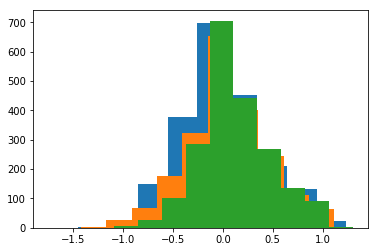

In [779]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(als.U[:, 0])
plt.hist(als.U[:, 1])
plt.hist(als.U[:, 15])

(array([  2.00000000e+00,   3.00000000e+00,   1.50000000e+01,
          2.28000000e+02,   1.12400000e+03,   4.44500000e+03,
          3.30600000e+03,   7.85000000e+02,   1.71000000e+02,
          7.00000000e+00]),
 array([-2.08475009, -1.7355172 , -1.38628431, -1.03705142, -0.68781852,
        -0.33858563,  0.01064726,  0.35988016,  0.70911305,  1.05834594,
         1.40757884]),
 <a list of 10 Patch objects>)

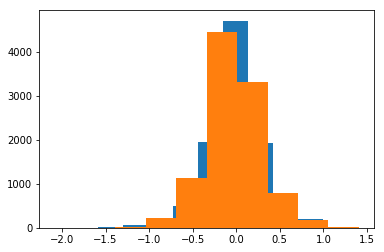

In [780]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(als.VT.T[:, 17])
plt.hist(als.VT.T[:, 5])

Maybe it does not hold for $V$.

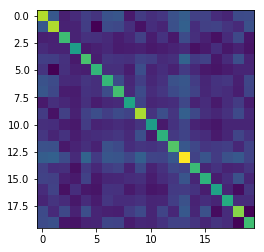

In [781]:
%matplotlib inline

cov = np.cov(als.U.T)
plt.imshow(cov)

In [782]:
np.diag(cov)

array([ 0.16343454,  0.16291754,  0.13109024,  0.10961346,  0.13494265,
        0.12634172,  0.12688704,  0.13281002,  0.11408947,  0.16153174,
        0.10862025,  0.12413041,  0.13800522,  0.18302343,  0.13009754,
        0.12390844,  0.11230994,  0.11864874,  0.1527546 ,  0.1314652 ])

In [783]:
als.U.shape

(2071, 20)

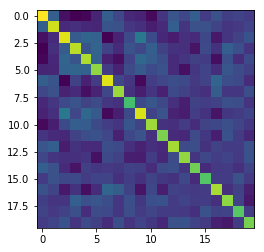

In [784]:
%matplotlib inline

cov = np.cov(als.VT)
plt.imshow(cov)

In [785]:
np.diag(cov)

array([ 0.11935564,  0.10965331,  0.11258604,  0.10526888,  0.10294797,
        0.09717179,  0.11277975,  0.09943299,  0.0798758 ,  0.11171786,
        0.09984569,  0.09266063,  0.1013008 ,  0.09744366,  0.09063436,
        0.08372662,  0.10193127,  0.09663016,  0.08453376,  0.09207398])

Learned components are independent.

In [786]:
als.means.mean()  # Global bias

3.2180201255399283

In [789]:
162 in i_test

False

In [796]:
users = list(i_test)
users.sort(key=lambda user_id: mangaki[user_id, :].getnnz())

In [797]:
len(users)

415

In [1166]:
PIG = users[200]
# 162=JJ
pig = mangaki[PIG, :]
all_ratings = pig.data
#all_ratings -= als.means.mean()
pig.getnnz()

72

In [1244]:
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression

ALPHA = 0.5

kernel = 1 * DotProduct(sigma_0=0.5)  # Kernel that will be used for both GP and DPP
gpr = GaussianProcessRegressor(kernel=kernel, alpha=ALPHA, optimizer=None, normalize_y=False)  # , optimizer=None
lr = LinearRegression()

In [1245]:
work_ids = pig.indices[START_PRED:]
user_ids = [PIG] * len(work_ids)
y_pred = als.predict(np.column_stack((user_ids, work_ids)))
mean_squared_error(pig.data[START_PRED:], y_pred) ** 0.5

4.5104394043066485

In [1246]:
work_ids = pig.indices
ratings = pig.data
lr.fit(als.VT.T[work_ids], ratings)
y_pred = lr.predict(als.VT.T[work_ids])
mean_squared_error(pig.data, y_pred) ** 0.5

0.64340653299459161

In [1247]:
pig.getnnz()

82

stupid has rmse 4.65780226622
0.331834533347
3.5121716218 to 0.685279529619


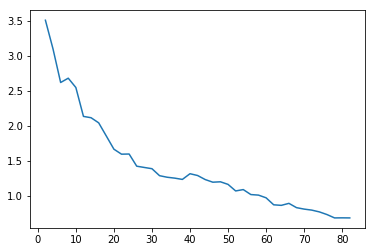

In [1248]:
from sklearn.metrics import mean_squared_error

def fix(x):
    x[x > 6] = 6
    x[x < 1] = 1

START_PRED = 0
    
BATCH_SIZE = 2
steps = []
errors = []
print('stupid has rmse', mean_squared_error(pig.data[START_PRED:], [0.] * len(pig.data[START_PRED:])) ** 0.5)
for t in range(BATCH_SIZE, pig.getnnz() + 1, BATCH_SIZE):  # pig.getnnz() + 1
    steps.append(t)
    work_ids = pig.indices[:t]
    ratings = pig.data[:t]
    gpr.fit(als.VT.T[work_ids], ratings)
    y_pred, sigma = gpr.predict(als.VT.T[pig.indices[START_PRED:]], return_std=True)
    #fix(y_pred)
    rmse = mean_squared_error(pig.data[START_PRED:], y_pred) ** 0.5
    errors.append(rmse)
    #print(t, 'rmse', rmse)
    eig = np.linalg.eig(gpr.L_)[0]
    #print('eigenvalues', eig.min(), 'to', eig.max())
    #print('alpha max', gpr.alpha_.max())
    #print(y_pred[START_PRED:START_PRED+5], pig.data[START_PRED:START_PRED+5])
    #print(y_pred)
    lr.fit(als.VT.T[work_ids], ratings)
    y_pred = lr.predict(als.VT.T[pig.indices])
    rmse = mean_squared_error(pig.data, y_pred) ** 0.5
    #print(t, 'rmse', rmse)
    #print(y_pred[:5], pig.data[:5])
    #print(y_pred)
    #print(pig.data)
    #print(pig.indices[y_pred > 10])
print(sigma.mean())
print(max(errors), 'to', min(errors))
plt.plot(steps, errors)

In [1249]:
# gpr.alpha_  # Learned weights for prediction

In [1250]:
# gpr.kernel_  # Learned kernel, should not move

In [1251]:
# np.diag(gpr.L_)  # Learned cholesky of kernel of train

(array([ 310.,   59.,   21.,   16.,    1.,    3.,    0.,    2.,    1.,
           1.,    0.,    0.,    0.,    0.,    1.]),
 array([  1.00000000e+00,   2.05066667e+02,   4.09133333e+02,
          6.13200000e+02,   8.17266667e+02,   1.02133333e+03,
          1.22540000e+03,   1.42946667e+03,   1.63353333e+03,
          1.83760000e+03,   2.04166667e+03,   2.24573333e+03,
          2.44980000e+03,   2.65386667e+03,   2.85793333e+03,
          3.06200000e+03]),
 <a list of 15 Patch objects>)

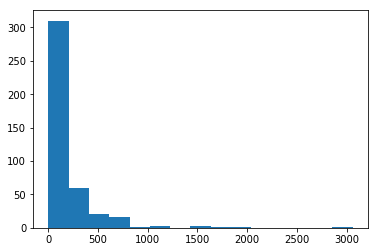

In [1252]:
plt.hist([mangaki[user_id, :].getnnz() for user_id in i_test], 15)

## Linear kernel

In [1253]:
len(pig.indices)

82

In [1254]:
from mangaki.utils.dpp2 import MangakiDPP
from sklearn.gaussian_process.kernels import RBF

def prepare_dpp(rated):
    #rbf = RBF()
    #rated = als.VT.T[pig.indices]
    dpp = MangakiDPP(vectors=rated, REPEAT=5)
    #dpp.compute_similarity(kernel)
    dpp.L = kernel(rated) + ALPHA * np.eye(len(rated))
    #dpp.L = rbf(rated)# + np.eye(len(rated))
    dpp.preprocess()
    return dpp

In [1255]:
inter = set(range(10086))
for user in users[390:500]:
    inter &= set(mangaki[user, :].indices)
print(len(inter))

16


In [1256]:
inter = set(range(150))
c = []
for user in users[250:500]:
    c.append(len(set(mangaki[user, :].indices) & inter))
print(np.mean(c), 1.96 * np.std(c))

88.7151515152 68.6435324868


In [1257]:
rated = als.VT.T[pig.indices]
dpp = prepare_dpp(rated)
dpp.sample_k(5)

array([ 8, 10, 20, 26, 72])

In [1258]:
#all_vectors = als.VT.T[pig.indices]  # pig.indices
#all_vectors = als.VT.T[:25]

def bgs(rated, nb_questions_min):
    #global all_vectors
    nb_works = len(rated)
    rated_works = range(nb_works)  # pig.getnnz()
    #P = all_vectors[rated_works].dot(all_vectors[rated_works].T)
    P = kernel(rated) + ALPHA * np.eye(len(rated_works))
    # print(nb_works, nb_questions)
    kept_indices = set(range(nb_works))
    get_bgs = {len(kept_indices): np.array(list(kept_indices))}
    for _ in range(nb_works - nb_questions_min):
        k_best = None
        #error_min = float('inf')
        error_max = float('-inf')
        for k in kept_indices:
            kept = list(kept_indices - set([k]))
            try:
                #error = np.trace(np.linalg.inv(P[np.ix_(kept, kept)]))
                vp = np.abs(np.real(np.linalg.eig(P[np.ix_(kept, kept)])[0]))
                if type(vp[0]) == np.complex128:
                    print(vp)
                    raise Exception
                #error = hmean(vp)
                error = np.sum(np.log(vp))
                #print(error, vp[-1])
            except Exception as err:
                print('I had to take', nb_questions_min, 'but I must stop at', len(kept_indices))
                print(err)
                return list(kept_indices)
            #print(error)
            if error > error_max:#< error_min:
                #error_min = error
                error_max = error
                k_best = k
            '''if len(kept) <= 2 and random.random() < 0.1:
                print(kept, error, vp)'''
        kept_indices -= set([k_best])
        get_bgs[len(kept_indices)] = np.array(list(kept_indices))
    sampled_indices = list(kept_indices)
    return np.array(sampled_indices), get_bgs

In [1233]:
_, get_bgs = bgs(rated, 2)

In [1259]:
for pos in [40, 240, 250, 340, len(users) - 1]:
    print(mangaki[users[pos], :].getnnz())
print(len(users), 'users')

7
106
125
264
3062
415 users


In [1260]:
popular = als.VT.T[:100]
popular_dpp = prepare_dpp(popular)

100 25
101 26


/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


102 26
103 26
104 26
105 27
106 27
107 27
108 27
109 28
110 28
111 28
112 28
113 29
114 30
115 30
116 30
117 31
118 31
119 31
120 31
121 32
122 32
123 33
124 33
125 33
126 34
127 35
128 35
129 35
130 35
131 35
132 36
133 36
134 37
135 37
136 38
137 38
138 38
139 40
140 41
141 41
142 42
143 42
144 43
145 44
146 44
147 44
148 45
149 45
150 47
151 47
152 47
153 48
154 49
155 49
156 50
157 50
158 51
159 51
160 51
161 52
162 53
163 54
164 54
165 55
166 56
167 56
168 56
169 57


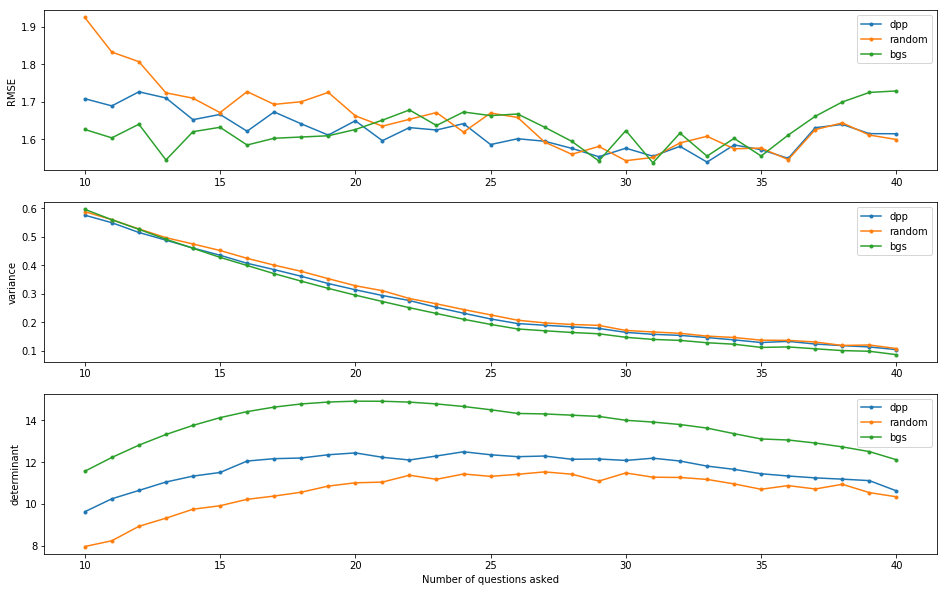

In [1275]:
import random
from collections import defaultdict

fig, axes = plt.subplots(3, 1, figsize=(16, 10))
plot = {}
plot['rmse'], plot['sigma'], plot['det'] = axes

STRATEGIES = ['dpp', 'random', 'bgs'] # , ':'bgs', 
LIMIT_SAMPLE = 200
LIMIT_ASK = 40

values = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for user_pos in range(100, 170):
    pig = mangaki[users[user_pos], :]
    #pig.data -= als.means.mean()  # Renormalize
    nb_total_rated = min(pig.getnnz(), LIMIT_SAMPLE)
    if user_pos % 1 == 0:
        print(user_pos, nb_total_rated)
    rated = als.VT.T[pig.indices[:LIMIT_SAMPLE]]  # LIMIT_SAMPLE is the limit
    if user_pos <= 240:
        dpp = prepare_dpp(rated)  # DPP
        _, get_bgs = bgs(rated, 1)  # BGS
    sizes = range(10, min(nb_total_rated, 40) + 1)
    for nb_rated in sizes:
        for strategy in STRATEGIES:
            if strategy == 'random':
                pos = random.sample(range(nb_total_rated), nb_rated)
                work_ids = pig.indices[pos]
            elif strategy == 'dpp':
                if user_pos <= 240:
                    pos = dpp.sample_k(nb_rated)
                    work_ids = pig.indices[pos]
                else:
                    pop = popular_dpp.sample_k(nb_rated)
                    askable = list(set(pop) & set(pig.indices))
                    if len(askable) < nb_rated:
                        remaining = nb_rated - len(askable)
                        #print(pos, 'oops', remaining, nb_rated)
                        askable.extend(random.sample(set(pig.indices) - set(askable), remaining))
                    work_ids = askable
            else:
                pos = get_bgs[nb_rated]
                work_ids = pig.indices[pos]
            ratings = pig[:, work_ids].data

            X_asked = als.VT.T[work_ids]
            values['det'][strategy][nb_rated].append(np.log(np.linalg.det(kernel(X_asked) + ALPHA * np.eye(nb_rated))))

            #print(work_ids.shape, X_asked.shape, ratings.shape)
            gpr.fit(X_asked, ratings)
            y_pred, sigma = gpr.predict(als.VT.T[pig.indices], return_std=True)
            #fix(y_pred)
            rmse = mean_squared_error(pig.data, y_pred) ** 0.5
            #rmse_max = mean_squared_error(pig.data, y_pred + 1.96 * sigma) ** 0.5
            #rmse_min = mean_squared_error(pig.data, y_pred - 1.96 * sigma) ** 0.5
            values['sigma'][strategy][nb_rated].append(sigma.mean())
            #values['sigma_err'][strategy][nb_rated].append(1.96 * sigma.std())
            values['rmse'][strategy][nb_rated].append(rmse)
            #values['rmse_up'][strategy].append(rmse_up)
            #values['rmse_down'][strategy].append(rmse_down)
            #print(nb_rated, strategy, 'rmse', rmse)
            #print(y_pred[:5], pig.data[:5])

curves = defaultdict(list)
for strategy in STRATEGIES:
    for value in ['sigma', 'rmse', 'det']:
        mean = [np.mean(values[value][strategy][nb_rated]) for nb_rated in sizes]
        std = [np.std(values[value][strategy][nb_rated]) for nb_rated in sizes]
        curves[value].append(plot[value].errorbar(sizes, mean, label=strategy, fmt='.-'))  # , yerr=1.96 * np.array(std)
for value in ['rmse', 'sigma', 'det']:
    plot[value].legend(handles=curves[value])
plt.xlabel('Number of questions asked')
plot['rmse'].set_ylabel('RMSE')
plot['det'].set_ylabel('determinant')
plot['sigma'].set_ylabel('variance')
plt.show()

In [1044]:
import pickle

backup = {}
for value in values:
    backup[value] = {}
    for strategy in STRATEGIES:
        backup[value][strategy] = {}
        for nb_rated in sizes:
            backup[value][strategy][nb_rated] = values[value][strategy][nb_rated]

'''with open('values40-240.pickle', 'wb') as f:
    pickle.dump(backup, f)'''

with open('values40-240.pickle', 'rb') as f:
    backup2 = pickle.load(f)

len(backup)

3

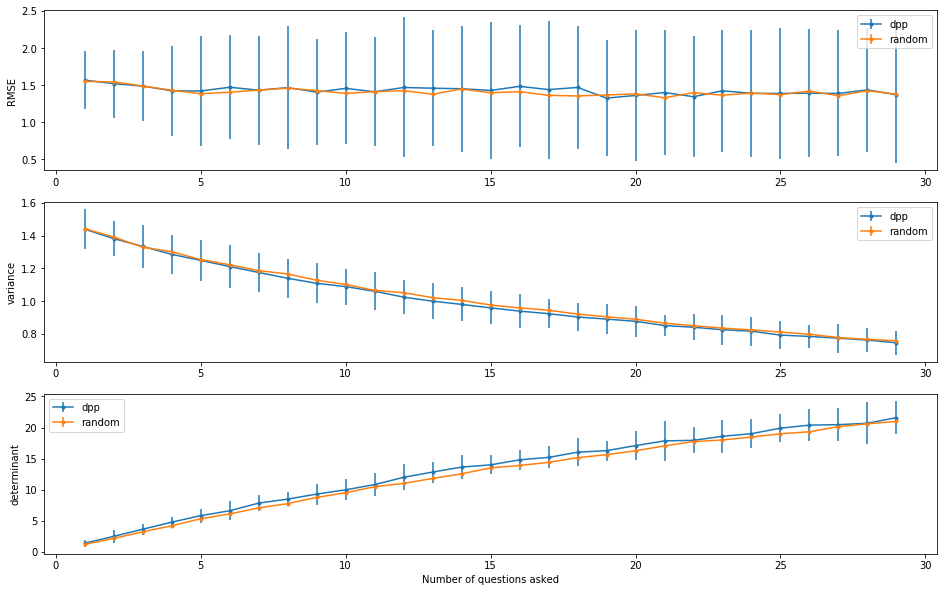

In [1272]:
subsizes = range(1, 30)

fig, axes = plt.subplots(3, 1, figsize=(16, 10))
plot = {}
plot['rmse'], plot['sigma'], plot['det'] = axes

curves = defaultdict(list)
for strategy in STRATEGIES:
    for value in ['sigma', 'rmse', 'det']:
        mean = [np.mean(backup[value][strategy][nb_rated]) for nb_rated in subsizes]
        std = [np.std(backup[value][strategy][nb_rated]) for nb_rated in subsizes] if strategy != 'random' else [0.] * len(subsizes)
        curves[value].append(plot[value].errorbar(subsizes, mean, yerr=1.96 * np.array(std), label=strategy, fmt='.-'))  # 
for value in ['rmse', 'sigma', 'det']:
    plot[value].legend(handles=curves[value])
plt.xlabel('Number of questions asked')
plot['rmse'].set_ylabel('RMSE')
plot['det'].set_ylabel('determinant')
plot['sigma'].set_ylabel('variance')
plt.show()

In [1066]:
P = np.random.random((5, 2))

In [1067]:
_, sigma, _ = np.linalg.svd(P)

In [1068]:
sigma ** 2

array([ 2.75481025,  0.24023893])

In [1070]:
np.linalg.svd(P.dot(P.T))

(array([[-0.6921513 ,  0.61451124,  0.17817563,  0.26389984, -0.20472623],
        [-0.20591154, -0.31782178,  0.63565118, -0.54018261, -0.40092404],
        [-0.20363248, -0.22904383, -0.66783424, -0.07297943, -0.67434722],
        [-0.28935687,  0.2371035 , -0.34228285, -0.74879228,  0.42685725],
        [-0.59441856, -0.6424065 , -0.03226308,  0.26933948,  0.40049445]]),
 array([  2.75481025e+00,   2.40238935e-01,   5.85678773e-17,
          3.30167623e-17,   5.02983733e-18]),
 array([[-0.6921513 , -0.20591154, -0.20363248, -0.28935687, -0.59441856],
        [ 0.61451124, -0.31782178, -0.22904383,  0.2371035 , -0.6424065 ],
        [ 0.35382594, -0.19257944,  0.00345917, -0.91015434,  0.09657884],
        [ 0.10187211,  0.75202175, -0.62990142, -0.13240423, -0.09888724],
        [-0.08793059, -0.5039506 , -0.71364204,  0.1189232 ,  0.46354537]]))

In [1072]:
np.linalg.svd(P[[1, 2, 4], :])[1]

array([ 1.15700538,  0.04186263])

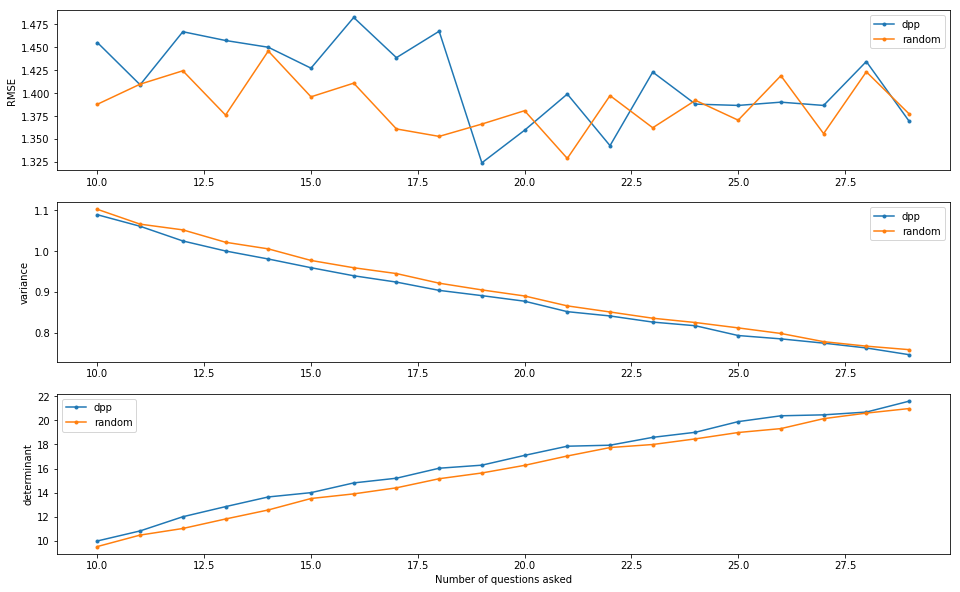

In [1046]:
subsizes = range(10, 30)

fig, axes = plt.subplots(3, 1, figsize=(16, 10))
plot = {}
plot['rmse'], plot['sigma'], plot['det'] = axes

curves = defaultdict(list)
for strategy in STRATEGIES:
    for value in ['sigma', 'rmse', 'det']:
        mean = [np.mean(values[value][strategy][nb_rated]) for nb_rated in subsizes]
        std = [np.std(values[value][strategy][nb_rated]) for nb_rated in subsizes] if strategy != 'random' else [0.] * len(subsizes)
        curves[value].append(plot[value].errorbar(subsizes, mean, label=strategy, fmt='.-'))  # 
for value in ['rmse', 'sigma', 'det']:
    plot[value].legend(handles=curves[value])
plt.xlabel('Number of questions asked')
plot['rmse'].set_ylabel('RMSE')
plot['det'].set_ylabel('determinant')
plot['sigma'].set_ylabel('variance')
plt.show()

In [769]:
from itertools import combinations

P = kernel(all_vectors) + 0.5 * np.eye(len(all_vectors))
det_max = 0.
best_subset = None
for subset in combinations(range(49), 3):
    vp = np.linalg.eig(P[np.ix_(subset, subset)])[0]
    det = np.sum(np.log(vp))
    if det > det_max:
        det_max = det
        best_subset = subset
print(best_subset, det_max)

(8, 18, 48) 4.25460508524


In [763]:
nb_rated = 3
rnd_ids = lambda: random.sample(range(total_rated), nb_rated)
bgs_ids = get_bgs[nb_rated]
dpp_ids = lambda: dpp.sample_k(nb_rated)

In [764]:
bgs_ids

array([ 8, 18, 48])

In [765]:
NB_SAMPLES = 10  # ('god', np.array(best_subset)), 
for strategy, pos in [('god', np.array(best_subset)), ('bgs', bgs_ids)] + [('dpp', dpp_ids()) for _ in range(NB_SAMPLES)] + [('rnd', rnd_ids()) for _ in range(NB_SAMPLES)]:
    cov = kernel(als.VT.T[pig.indices[pos]]) + 0.5 * np.eye(nb_rated)
    #plt.imshow(cov)
    print(strategy, np.linalg.det(cov), np.trace(cov), np.trace(np.linalg.inv(cov)))
    #plt.show()

god 70.428998245 12.9441472155 0.757048278569
bgs 70.428998245 12.9441472155 0.757048278569
dpp 39.6364976041 10.749006229 0.920698124954
dpp 47.5691573891 12.0751859134 0.913087202165
dpp 28.9860274404 9.97273072551 1.04952507028
dpp 40.4860914178 11.0070400776 0.925982264811
dpp 52.9832951942 12.2298801317 0.866642658198
dpp 37.6991738559 12.2264444503 1.04461854464
dpp 37.2510220756 10.4558451907 0.93358365863
dpp 40.7199820761 10.6882025798 0.907200112806
dpp 32.615762504 9.82940546514 0.960959078829
dpp 38.6342799324 10.645916851 0.930801676432
rnd 13.5096342561 7.74426304244 1.35266112668
rnd 23.1677988068 9.62566559232 1.16302997412
rnd 17.2154364862 8.02089401437 1.20499127812
rnd 19.3745770673 8.53273213737 1.17739386033
rnd 31.005674663 10.2495882414 1.05029142943
rnd 10.0599828581 6.84954391492 1.46142696033
rnd 25.5118832817 9.82916640679 1.12204069636
rnd 23.9830055827 9.12229113671 1.09664290944
rnd 13.7155963789 8.00250932112 1.42226032884
rnd 14.6027854875 7.54182922008

In [766]:
pig.indices[rand_ids][9], pig.indices[rand_ids][11]

IndexError: index 151 is out of bounds for axis 1 with size 49

## RBF kernel

In [1262]:
from sklearn.gaussian_process.kernels import RBF

In [1263]:
rated = als.VT.T[pig.indices]
rbf = RBF()
dpprbf = MangakiDPP(vectors=rated)
dpprbf.L = rbf(dpprbf.vectors)
dpprbf.preprocess()

1 random rmse 4.27935090529
[ 0.51258691  0.91682174  0.47498329  0.2876038   0.28939948] [ 5.  5.  5.  5.  5.]
1 dpp rmse 4.20637988589
[ 0.35731215  0.33563606  0.28253561  0.09054751  0.10838086] [ 5.  5.  5.  5.  5.]
1 bgs rmse 4.20637988589
[ 0.35731215  0.33563606  0.28253561  0.09054751  0.10838086] [ 5.  5.  5.  5.  5.]
3 random rmse 2.79095662783
[ 3.16921095  5.          2.33057922  1.25717254  1.32888584] [ 5.  5.  5.  5.  5.]
3 dpp rmse 2.64087840477
[ 2.03999078  1.6819938   1.83403253  4.43786516  5.        ] [ 5.  5.  5.  5.  5.]
3 bgs rmse 3.42396694391
[ 1.37550333  1.49141919  2.00705889  0.67248161  0.78390395] [ 5.  5.  5.  5.  5.]
5 random rmse 2.46261601896
[ 1.53930775  1.8228411   2.05841234  3.01484393  2.68280195] [ 5.  5.  5.  5.  5.]
5 dpp rmse 2.1556017382
[ 3.4961696   5.          2.85015691  3.47415243  3.32982134] [ 5.  5.  5.  5.  5.]
5 bgs rmse 2.56825159623
[ 1.92240619  2.04847341  2.53725847  1.27978761  1.30740153] [ 5.  5.  5.  5.  5.]
7 random rm

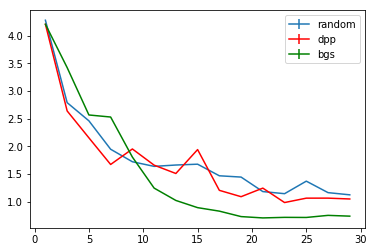

In [1271]:
import random
from collections import defaultdict

kernel = DotProduct()
gpr = GaussianProcessRegressor()
BATCH_SIZE = 40
steps = []
errors = defaultdict(list)
errors_min = defaultdict(list)
errors_max = defaultdict(list)
total_rated = pig.getnnz()
for nb_rated in range(1, 30, 2):
    steps.append(nb_rated)
    for strategy in ['random', 'dpp', 'bgs']:
        if strategy == 'random':
            pos = random.sample(range(total_rated), nb_rated)
        elif strategy == 'dpp':
            pos = dpprbf.sample_k(nb_rated)
        elif strategy == 'bgs':
            pos = get_bgs[nb_rated]
        work_ids = pig.indices[pos]
        ratings = pig.data[pos]
        
        gpr.fit(als.VT.T[work_ids], ratings)
        y_pred, sigma = gpr.predict(als.VT.T[pig.indices], return_std=True)
        rmse = mean_squared_error(pig.data, y_pred) ** 0.5
        rmse_max = mean_squared_error(pig.data, y_pred + 1.96 * sigma) ** 0.5
        rmse_min = mean_squared_error(pig.data, y_pred - 1.96 * sigma) ** 0.5
        errors[strategy].append(rmse)
        errors_max[strategy].append(0)#abs(rmse_max - rmse))
        errors_min[strategy].append(0)#abs(rmse_min - rmse))
        print(nb_rated, strategy, 'rmse', rmse)
        print(y_pred[:5], pig.data[:5])
rand_curve = plt.errorbar(steps, errors['random'], yerr=[errors_min['random'], errors_max['random']], label='random')
dpp_curve = plt.errorbar(steps, errors['dpp'], yerr=[errors_min['dpp'], errors_max['dpp']], color='r', label='dpp')
bgs_curve = plt.errorbar(steps, errors['bgs'], yerr=[errors_min['bgs'], errors_max['bgs']], color='g', label='bgs')

plt.legend(handles=[rand_curve, dpp_curve, bgs_curve])
plt.show()

In [201]:
X = np.random.random((5, 2))*100
eig, _ = np.linalg.eig(X.dot(X.T))

In [204]:
np.round(eig)

array([ 18630.,     -0.,   3416.,      0.,     -0.])